# 3 Generalization
## Can network fit random labels?
* Train on MNIST

In [ ]:
import numpy as np
from pylab import imshow
import matplotlib.pyplot as plt

In [ ]:
# Fetch and load mnist data
def fetch(url):
  import requests, gzip, os, hashlib
  filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(filepath):
    with open(filepath, "rb") as f:
      data = f.read()
  else:
    with open(filepath, "wb") as f:
      data = requests.get(url).content
      f.write(data)
  return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

train_image_data = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
train_labels_data = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
test_image_data = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
test_labels_data = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")



In [ ]:
### Clean data
# Remove non image/non-label data (i.e. magic number, num_images/num_items,
# num_rows, num_columns, etc)
relevant_train_img_d = train_image_data[0x10:]
Y_train = train_labels_data[8:]
relevant_test_img_d = test_image_data[0x10:]
Y_test = test_labels_data[8:]
print("Y_test", Y_test)
print("Y_test.shape", Y_test.shape)

# Each image is made of 28 rows and 28 columns (a matrix of 28x28) with a 
# value between 0 and 255 that represents a black and white color scale
# (0 = black and 255 = white)
# Reshape data to create a matrix of 28 rows and 28 columns
# -1 means that we have an unknown dimension and we want numpyt to figure it out
X_train = relevant_train_img_d.reshape((-1,28,28))
X_test = relevant_test_img_d.reshape((-1,28,28))

print("X_train shape:", X_train.shape) # X_train -> 60,000 matrices of 28x28
print("Y_train shape", Y_train.shape) # Y_train -> 60,000 labels 

Y_test [7 2 1 ... 4 5 6]
Y_test.shape (10000,)
X_train shape: (60000, 28, 28)
Y_train shape (60000,)


# Model
* An input layer of size 28 * 28 = 784
* Each image is made of 28 rows and 28 columns 
* Two hidden layers 
    ** (784, 128) with ReLU activation function
    ** (128, 64) with ReLU activation function
* One output layer with dimension (64, 10)

* Uses softmax activation function (softmax are used with classification problems)

In [ ]:
# model
import torch
import torch.nn as nn

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(784, 128) # 28*28 = 728
    self.activation = nn.ReLU()
    self.linear2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.linear2(x)
    return x

#print(model, len(list(model.parameters())))

In [ ]:
rnd_model = Model()
# Training loop
epochs = 1000

#BATCH_SIZE = 64
BATCH_SIZE = 128
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(rnd_model.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(rnd_model.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
train_loss_values_rnd_model = []
train_accuracy_values_rnd = []


for epoch in range(epochs):
    # SHUFFLE LABELS BEFORE TRAINING
    shuffled_sample_index = np.random.randint(0, X_train.shape[0], size=(len(X_train)))

    X = X_train[shuffled_sample_index]
    X = torch.tensor(X.reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[shuffled_sample_index])

    optimizer.zero_grad()

    y_prediction = rnd_model(X)

    # Calculate accuracy
    max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
    accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
    train_accuracy_values_rnd.append(accuracy)
    #print(accuracy.item())

    loss = loss_function(y_prediction, Y)

    loss.backward()

    optimizer.step()
    #print(loss.item())
    epoch_count.append(epoch)
    train_loss_values_rnd_model.append(loss.item())


    if (epoch % 100 == 0):
        print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")

Epoch: 0 ,Loss: 31.651288986206055, | Accuracy: 0.09211666882038116
Epoch: 100 ,Loss: 0.6112049221992493, | Accuracy: 0.8607333302497864
Epoch: 200 ,Loss: 0.4257178008556366, | Accuracy: 0.8962833285331726
Epoch: 300 ,Loss: 0.35214024782180786, | Accuracy: 0.9112333059310913
Epoch: 400 ,Loss: 0.29490771889686584, | Accuracy: 0.9229333400726318
Epoch: 500 ,Loss: 0.2625716030597687, | Accuracy: 0.9288666844367981
Epoch: 600 ,Loss: 0.24542148411273956, | Accuracy: 0.9350000023841858
Epoch: 700 ,Loss: 0.22587135434150696, | Accuracy: 0.9388666749000549
Epoch: 800 ,Loss: 0.20126356184482574, | Accuracy: 0.9459999799728394
Epoch: 900 ,Loss: 0.1867285519838333, | Accuracy: 0.9487333297729492


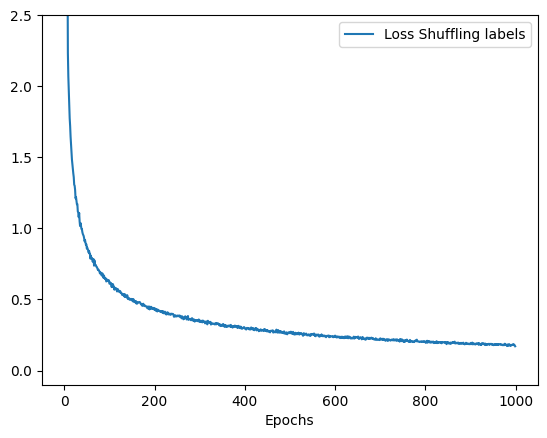

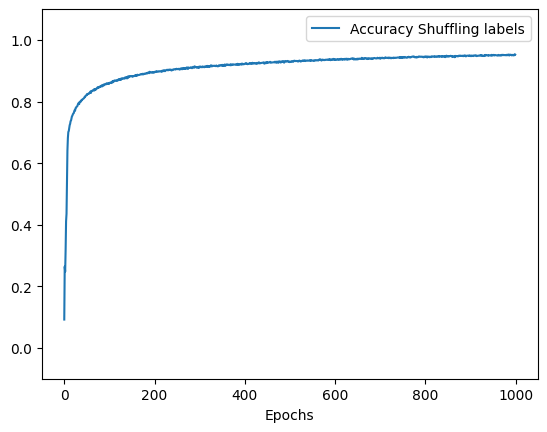

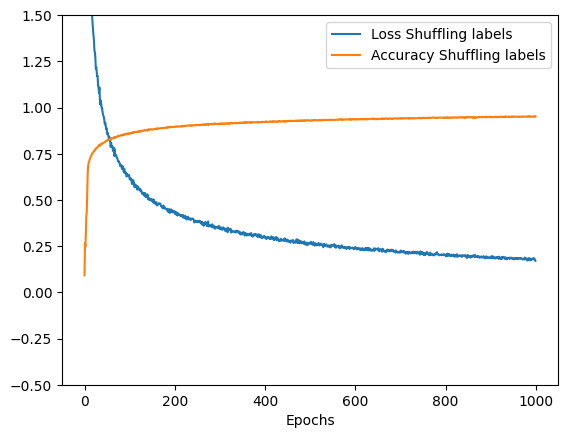

In [ ]:
plt.plot(epoch_count, train_loss_values_rnd_model, label="Loss Shuffling labels")
#plt.plot(epoch_count, test_loss_values_rnd_model, label="Loss Shuffling labels")
plt.ylim(-0.1, 2.5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count, train_accuracy_values_rnd, label="Accuracy Shuffling labels")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count, train_loss_values_rnd_model, label="Loss Shuffling labels")
plt.plot(epoch_count, train_accuracy_values_rnd, label="Accuracy Shuffling labels")
plt.ylim(-0.5, 1.5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

## Can network fit random labels?
* This was a confusing question (like most of them!!!) the question says "these" how do we get THOSE EXACT IMAGES (NUMBERS)???
* Since we have the the MNIST database loaded why not try with random images from the test set??? That is a far better test than 64 arbitrary images.

Images to test:


<Figure size 100x100 with 0 Axes>

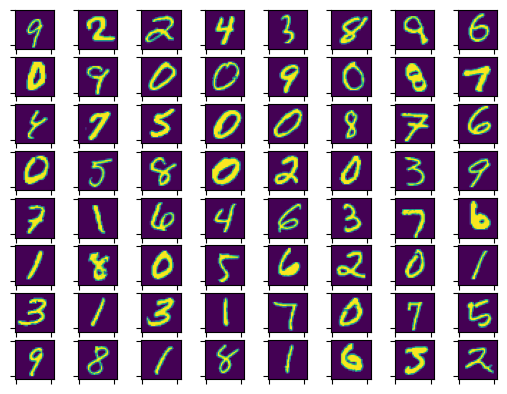

Predictions:
[[9 2 2 4 3 8 4 6]
 [0 9 0 0 9 0 9 7]
 [8 7 5 0 0 8 7 6]
 [0 5 8 0 2 0 3 9]
 [9 1 6 4 6 3 7 6]
 [1 8 0 5 6 2 0 1]
 [3 1 3 1 7 0 7 5]
 [9 8 1 8 1 6 3 2]]


In [ ]:
# To get the prediction from our model we simply have
# to compute the the weighted sum of the input (a 28*28 matrix)
# and the final weights of our model
import matplotlib.pyplot as plt

def get_prediction(x):
    # get weights from model
    l1 = rnd_model.linear1.weight.detach().numpy().T
    l2 = rnd_model.linear2.weight.detach().numpy().T
    y = x.reshape(1, -1).dot(l1)
    y = np.maximum(y, 0)
    y = y.dot(l2)
    return np.argmax(y) # argmax returns the index of best prediction (or the best predictions)

plt.figure(figsize=(1,1))
rows, columns = 8, 8
preds = np.zeros((rows, columns), dtype=np.int8)
f, a = plt.subplots(rows, columns)
for i in range(rows):
    for j in range(columns):
        rnd_index = np.random.randint(0,len(X_test))
        #rand_x = torch.tensor(X_test[rnd_index].reshape((-1, 28*28))).float()
        rand_x = X_test[rnd_index]
        #imshow(X_test[rnd_index])#, Y_test[1]
        prediction = get_prediction(rand_x)
        preds[i][j] = prediction
        a[i][j].imshow(rand_x)
        a[i][j].set_xticklabels([])
        a[i][j].set_yticklabels([])
print("Images to test:")
plt.show()
print("Predictions:")
print(preds)


# Flatness Vs Generalization
Visualize the line between two trained models

## Model:
* An input layer of size 28 * 28 = 784
* Each image is made of 28 rows and 28 columns 
* Two hidden layers 
    ** (784, 128) with ReLU activation function
    ** (128, 64) with ReLU activation function
* One output layer with dimension (64, 10)

* Uses softmax activation function (softmax are used with classification problems)


## Train two models (m1 and m2) with different training approach
    * Batch size m1 = 64
    * Batch size m2 = 1024

### Model 1 (m1)

In [ ]:
m1 = Model()
# Training loop
epochs = 1000

BATCH_SIZE = 64
#BATCH_SIZE = 128
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(m1.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(m1.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
loss_values_m1 = []
accuracy_values_m1 = []

for epoch in range(epochs):
  sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
  # sample from whole array
  X = X_train[sample]
  X = torch.tensor(X.reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[sample])

  optimizer.zero_grad()

  y_prediction = m1(X)

  # Calculate accuracy
  max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
  accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
  accuracy_values_m1.append(accuracy)

  loss = loss_function(y_prediction, Y)

  loss.backward()

  optimizer.step()
  epoch_count.append(epoch)
  loss_values_m1.append(loss.item())

  if (epoch % 100 == 0):
    print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")

Epoch: 0 ,Loss: 28.621288299560547, | Accuracy: 0.125
Epoch: 100 ,Loss: 1.0259697437286377, | Accuracy: 0.8125
Epoch: 200 ,Loss: 0.8788164258003235, | Accuracy: 0.828125
Epoch: 300 ,Loss: 0.2832823693752289, | Accuracy: 0.90625
Epoch: 400 ,Loss: 0.2677462100982666, | Accuracy: 0.90625
Epoch: 500 ,Loss: 0.3001459240913391, | Accuracy: 0.90625
Epoch: 600 ,Loss: 0.18827608227729797, | Accuracy: 0.96875
Epoch: 700 ,Loss: 0.3965643048286438, | Accuracy: 0.828125
Epoch: 800 ,Loss: 0.2497103065252304, | Accuracy: 0.890625
Epoch: 900 ,Loss: 0.5040270686149597, | Accuracy: 0.90625


### Model 2 (m2)
Batch size = 1024

In [ ]:
m2 = Model()
# Training loop
epochs = 1000

#BATCH_SIZE = 32
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(m2.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(m2.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
loss_values_m2 = []
accuracy_values_m2 = []

for epoch in range(epochs):
  sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
  # sample from whole array
  X = X_train[sample]
  X = torch.tensor(X.reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[sample])

  optimizer.zero_grad()

  y_prediction = m2(X)

  # Calculate accuracy
  max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
  accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
  accuracy_values_m2.append(accuracy)

  loss = loss_function(y_prediction, Y)

  loss.backward()

  optimizer.step()
  epoch_count.append(epoch)
  loss_values_m2.append(loss.item())

  if (epoch % 100 == 0):
    print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")


Epoch: 0 ,Loss: 26.58240509033203, | Accuracy: 0.1123046875
Epoch: 100 ,Loss: 0.6621792316436768, | Accuracy: 0.8486328125
Epoch: 200 ,Loss: 0.4792451560497284, | Accuracy: 0.8876953125
Epoch: 300 ,Loss: 0.3476565182209015, | Accuracy: 0.908203125
Epoch: 400 ,Loss: 0.2549283802509308, | Accuracy: 0.9345703125
Epoch: 500 ,Loss: 0.3029232621192932, | Accuracy: 0.91796875
Epoch: 600 ,Loss: 0.27542462944984436, | Accuracy: 0.9150390625
Epoch: 700 ,Loss: 0.18675179779529572, | Accuracy: 0.9462890625
Epoch: 800 ,Loss: 0.20128962397575378, | Accuracy: 0.9404296875
Epoch: 900 ,Loss: 0.20489761233329773, | Accuracy: 0.94921875


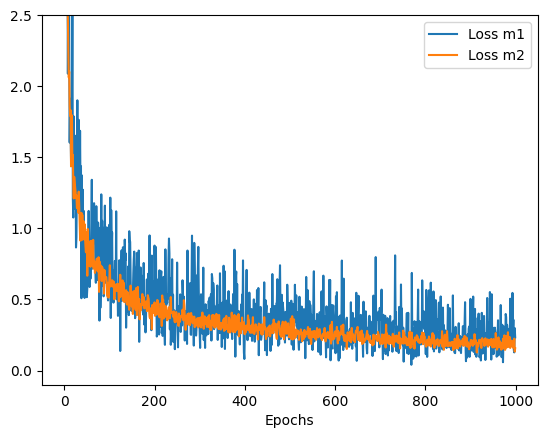

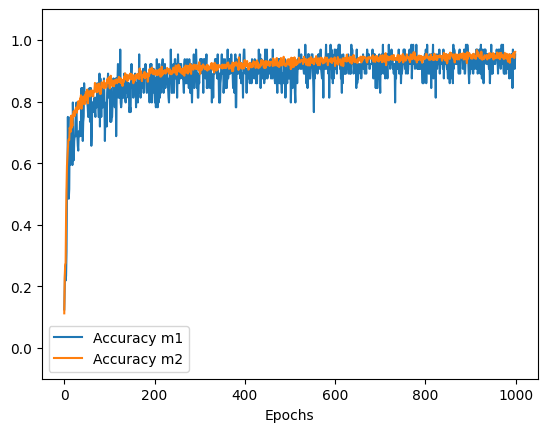

In [ ]:
plt.plot(epoch_count, loss_values_m1, label="Loss m1")
plt.plot(epoch_count, loss_values_m2, label="Loss m2")
plt.ylim(-0.1, 2.5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count, accuracy_values_m1, label="Accuracy m1")
plt.plot(epoch_count, accuracy_values_m2, label="Accuracy m2")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

Record the loss and accuracy of the model which is linear interpolation betwwen m1 and m2

shape m1 l1 (784, 128)
shape m1 l2 (128, 10)
<class 'numpy.ndarray'>


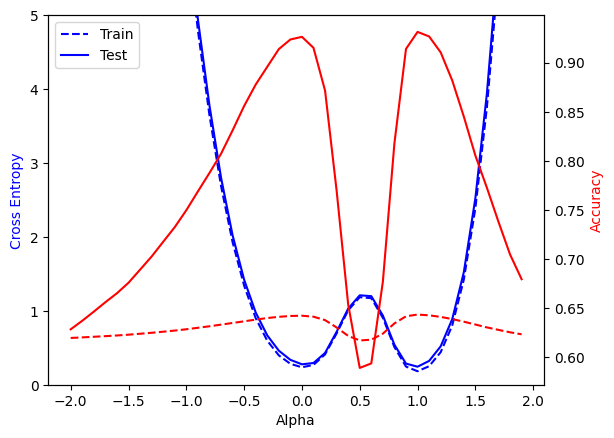

In [ ]:
# Get weights of m1
m1_l1 = m1.linear1.weight.detach().numpy().T
m1_l2 = m1.linear2.weight.detach().numpy().T

# Get weights of m2
m2_l1 = m2.linear1.weight.detach().numpy().T
m2_l2 = m2.linear2.weight.detach().numpy().T

print("shape m1 l1", m1_l1.shape)
print("shape m1 l2", m1_l2.shape)

# calculate θ⍺ = (1-⍺)θ1 + ⍺θ2

alpha_vals = np.array([*range(-20,20)],dtype=np.float32)
#print(alpha_vals)
alpha_vals = alpha_vals*0.1
#print(alpha_vals)

#list_alpha = []
list_entropy_train = []
list_accuracy_train = []

list_entropy_test = []
list_accuracy_test = []

for alpha in alpha_vals:
    lin_intrpl_m_l1 = ((1-alpha)* m1_l1) + alpha*m2_l1
    lin_intrpl_m_l2 = ((1-alpha)* m1_l2) + alpha*m2_l2
    #print("shape interpolation l1", lin_intrpl_m_l1.shape)
    #print("shape interpolation l2", lin_intrpl_m_l2.shape)

    # New model: linear interpolation of m1 and m2
    lin_intrpl_m = Model()
    lin_intrpl_m.linear1.weight = nn.Parameter(torch.tensor(lin_intrpl_m_l1.T))
    lin_intrpl_m.linear2.weight = nn.Parameter(torch.tensor(lin_intrpl_m_l2.T))

    
    
    # Evaluate new model: 
    # Get Entropy
    #train
    X_train_tensor = torch.tensor(X_train.reshape((-1, 28*28))).float()
    Y_train_preds = lin_intrpl_m(X_train_tensor)
    loss = nn.CrossEntropyLoss()
    entropy = loss(Y_train_preds, torch.tensor(Y_train))
    list_entropy_train.append(entropy.detach().numpy())
    # Get Accuracy
    Y_train_max = torch.argmax(Y_train_preds, dim=1).numpy()
    accuracy = (Y_train == Y_train_max).mean()
    list_accuracy_train.append(accuracy)
    
    ##
    #test
    X_test_tensor = torch.tensor(X_test.reshape((-1, 28*28))).float()
    Y_test_preds = lin_intrpl_m(X_test_tensor)
    loss = nn.CrossEntropyLoss()
    entropy = loss(Y_test_preds, torch.tensor(Y_test))
    list_entropy_test.append(entropy.detach().numpy())
    # Get Accuracy
    Y_test_max = torch.argmax(Y_test_preds, dim=1).numpy()
    accuracy = (Y_test == Y_test_max).mean()
    list_accuracy_test.append(accuracy)

fig, ax = plt.subplots()
print(type(list_entropy_test[0]))
ax.plot(alpha_vals, list_entropy_train, "--" , c="b", label="Train")
ax.plot(alpha_vals, list_entropy_test, c="b", label="Test")
ax.set_ylabel("Cross Entropy", c="b")
ax.set_ylim([0, 5])
ax.legend()

ax2 = ax.twinx()
ax.plot(alpha_vals, list_accuracy_train, "--" , c="r")
ax2.plot(alpha_vals, list_accuracy_test, c="r")
ax2.set_ylabel("Accuracy", c="r")
ax.set_xlabel("Alpha")

plt.show()


* Train at least 5 models with different training approach
* Record the loss and accuracy of all models
* Record the sensitivity of all models 

In [20]:
training_approaches = [32, 64, 128, 256, 512, 1028]
grads = []
list_sens = []
for i in range(len(training_approaches)):
    #Sensitivity
    m3 = Model()
    # Training loop
    epochs = 500

    #BATCH_SIZE = 32
    #BATCH_SIZE = 1024
    BATCH_SIZE = training_approaches[i]
    LEARNING_RATE = 0.001

    loss_function = nn.CrossEntropyLoss()

    #optimizer = torch.optim.Adam(m2.parameters(), lr=LEARNING_RATE) #Adam
    optimizer = torch.optim.SGD(m3.parameters(), lr=LEARNING_RATE) #SGD


    epoch_count = []
    loss_values_m2 = []
    accuracy_values_m2 = []

    total_norm = 0
    for epoch in range(epochs):
        sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
        # sample from whole array
        X = X_train[sample]
        X = X.reshape((-1, 28*28)).astype("float64")
        X = torch.tensor(X.reshape((-1, 28*28)), requires_grad=True).float()
        Y = torch.tensor(Y_train[sample])

        X.register_hook(lambda d:grads.append(d))
        #Y.register_hook(lambda d:grads.append(d))

        #print("len(grads)", len(grads))
        optimizer.zero_grad()

        y_prediction = m2(X)

        # Calculate accuracy
        max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
        accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
        accuracy_values_m2.append(accuracy)
        #print(accuracy.item())

        #loss.retain_grad()
        loss = loss_function(y_prediction, Y)
        loss.retain_grad()
        loss.backward()

        grad = loss.grad
        #print("grad", grad)
        param_norm = grad.data.norm(2)
        total_norm += param_norm.item() ** 2
        #print("total_norm", total_norm)
        
        #print("loss.grad",loss.grad)

        optimizer.step()
        #print(loss.item())
        epoch_count.append(epoch)
        loss_values_m2.append(loss.item())

        if (epoch % 100 == 0):
            print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")
    
    total_norm = 0
    for grad in grads:
        param_norm = grad.norm(2)
        total_norm = param_norm.item() ** 2
    sens = total_norm ** 0.5
    list_sens.append(sens)
    #print("total_norm", total_norm)
    #grads.append(total_norm)
    #print("total_norm", total_norm)

Epoch: 0 ,Loss: 0.15241365134716034, | Accuracy: 0.875
Epoch: 100 ,Loss: 0.22448420524597168, | Accuracy: 0.9375
Epoch: 200 ,Loss: 0.03541626036167145, | Accuracy: 1.0
Epoch: 300 ,Loss: 0.5886730551719666, | Accuracy: 0.90625
Epoch: 400 ,Loss: 0.04891977086663246, | Accuracy: 1.0
Epoch: 0 ,Loss: 0.049121685326099396, | Accuracy: 0.984375
Epoch: 100 ,Loss: 0.3154822289943695, | Accuracy: 0.890625
Epoch: 200 ,Loss: 0.3863687515258789, | Accuracy: 0.9375
Epoch: 300 ,Loss: 0.08196938037872314, | Accuracy: 0.953125
Epoch: 400 ,Loss: 0.10790912061929703, | Accuracy: 0.953125
Epoch: 0 ,Loss: 0.09505075961351395, | Accuracy: 0.953125
Epoch: 100 ,Loss: 0.1804167777299881, | Accuracy: 0.953125
Epoch: 200 ,Loss: 0.1394437849521637, | Accuracy: 0.9375
Epoch: 300 ,Loss: 0.31365057826042175, | Accuracy: 0.921875
Epoch: 400 ,Loss: 0.18337920308113098, | Accuracy: 0.9453125
Epoch: 0 ,Loss: 0.19289061427116394, | Accuracy: 0.93359375
Epoch: 100 ,Loss: 0.2928198277950287, | Accuracy: 0.921875
Epoch: 200

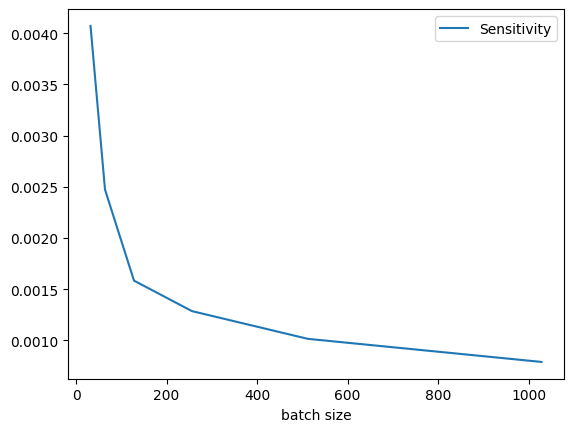

In [19]:
plt.plot(training_approaches, list_sens, label="Sensitivity")
plt.xlabel("batch size")
plt.legend()
plt.show()
#print("grads", len(grads))

In [21]:
# Train Model 
# Training loop
epochs = 1000

BATCH_SIZE = 64
#BATCH_SIZE = 128
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(rnd_model.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(lin_intrpl_m.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
loss_values_lin_intrpl_m = []
accuracy_values_lin_intrpl_m = []

for epoch in range(epochs):
  #sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
  # SHUFFLE LABELS BEFORE TRAINING
  shuffled_sample_index = np.random.randint(0, X_train.shape[0], size=(len(X_train)))
                                            
  # sample from whole array
  #X = X_train[sample]
  X = X_train[shuffled_sample_index]
  X = torch.tensor(X.reshape((-1, 28*28))).float()
  #Y = torch.tensor(Y_train[sample])
  Y = torch.tensor(Y_train[shuffled_sample_index])

  optimizer.zero_grad()

  y_prediction = lin_intrpl_m(X)

  # Calculate accuracy
  max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
  accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
  accuracy_values_lin_intrpl_m.append(accuracy)
  #print(accuracy.item())

  loss = loss_function(y_prediction, Y)

  loss.backward()

  optimizer.step()
  #print(loss.item())
  epoch_count.append(epoch)
  loss_values_lin_intrpl_m.append(loss.item())

  if (epoch % 100 == 0):
    print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")

Epoch: 0 ,Loss: 10.790074348449707, | Accuracy: 0.6815500259399414
Epoch: 100 ,Loss: 1.1257225275039673, | Accuracy: 0.9236000180244446
Epoch: 200 ,Loss: 0.8119868636131287, | Accuracy: 0.9340333342552185
Epoch: 300 ,Loss: 0.6758850812911987, | Accuracy: 0.9386500120162964
Epoch: 400 ,Loss: 0.5744954347610474, | Accuracy: 0.9430500268936157
Epoch: 500 ,Loss: 0.49748778343200684, | Accuracy: 0.947433352470398
Epoch: 600 ,Loss: 0.4472615420818329, | Accuracy: 0.9490166902542114
Epoch: 700 ,Loss: 0.3910318613052368, | Accuracy: 0.9523833394050598
Epoch: 800 ,Loss: 0.3621458411216736, | Accuracy: 0.9544166922569275
Epoch: 900 ,Loss: 0.32307887077331543, | Accuracy: 0.9574000239372253


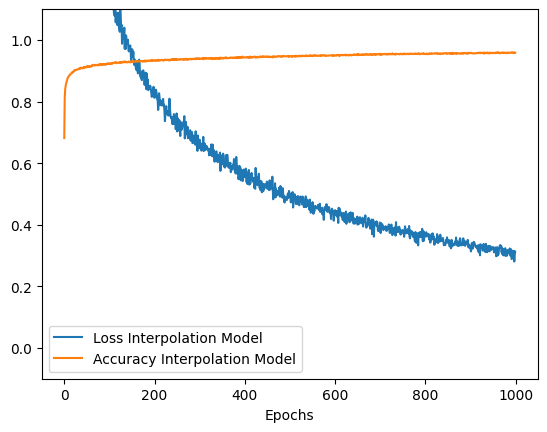

In [22]:
plt.plot(epoch_count, loss_values_lin_intrpl_m, label="Loss Interpolation Model")
plt.ylim(-0.1, 2.5)
plt.xlabel("Epochs")

plt.plot(epoch_count, accuracy_values_lin_intrpl_m, label="Accuracy Interpolation Model")
plt.ylim(-0.1, 1.1)

plt.legend()
plt.xlabel("Epochs")
plt.show()